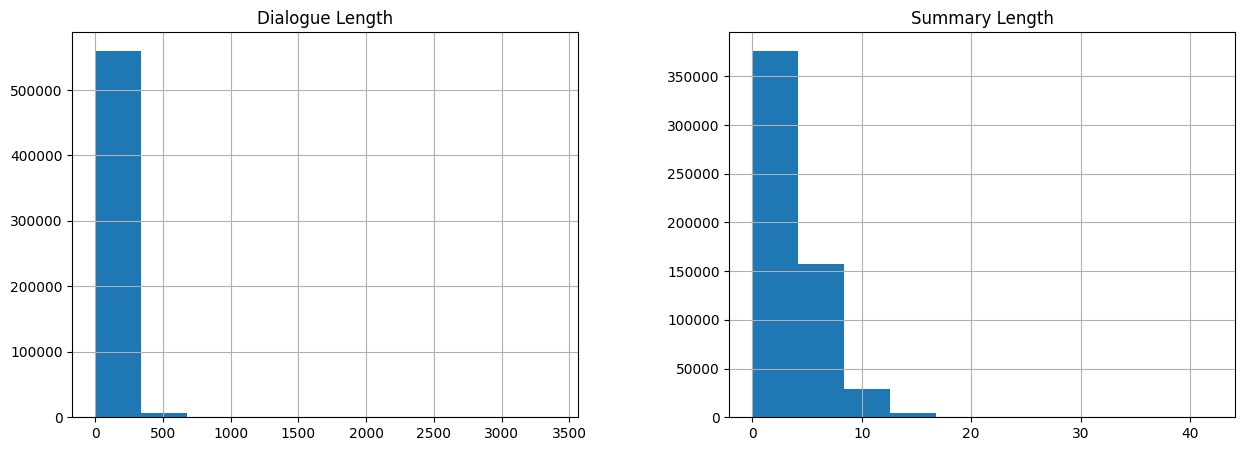

In [49]:
import pandas as pd
df=pd.read_csv("Reviews.csv")

import re
def cleaning(s):
    s = str(s)
    # Convert to lowercase
    s = s.lower()
    # Remove punctuation
    s = re.sub(r'[^\w\s]', '', s)
    # Remove digits
    s = re.sub(r'\d+', '', s)
    # Remove extra whitespaces
    s = re.sub(r'\s+', ' ', s)
    # Remove specific terms
    s = s.replace("https", "")
    s = s.replace("[\w*", "")
    return s

Text=[]
Summary=[]

for i in range(len(df)):
    s=cleaning(df.iloc[i]['Text'])
    Text.append(s)
    s=cleaning(df.iloc[i]['Summary'])
    Summary.append(s)
    
len_text=[len(Text[i].split()) for i in range(len(Text))]
len_summ=[len(Summary[i].split()) for i in range (len(Summary))]
data = pd.DataFrame([len_text, len_summ]).T
data.columns = ['Dialogue Length', 'Summary Length']
data.hist(figsize=(15,5))
new_data=pd.DataFrame([Text,Summary]).T
new_data.columns=['Text','Summary']

from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

from sklearn.model_selection import train_test_split

train_texts, test_texts,train_summaries, test_summaries = train_test_split(new_data['Text'], new_data['Summary'], test_size=0.25, random_state=42)

test_summaries.to_pickle('test_summaries.pkl')
test_texts.to_pickle('test_texts.pkl')

In [ ]:
from torch.utils.data import Dataset
# Custom dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, summaries, tokenizer):
        self.texts = texts
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_len = 1024  # Maximum input length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        summary = self.summaries.iloc[idx]

        input_ids = tokenizer.encode(text, max_length=1024, padding='max_length', truncation=True, return_tensors='pt')[0]
        labels = tokenizer.encode(summary, max_length=36, padding='max_length', truncation=True, return_tensors='pt')[0]
        attention_mask = torch.ones_like(input_ids)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


In [52]:
with open('train_texts.txt', 'w') as f:
    i=0
    for text in train_texts:
        f.write(f"Query: {text} TL;DR ")
        f.write(f"Summary: {train_summaries.iloc[i]}  \n")
        i+=1

def load_dataset(file_path, tokenizer, block_size = 154):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset
def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator
     

def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir)
      
  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
  )
      
  trainer.train()
  trainer.save_model()

train_file_path = 'train_texts.txt'
model_name = 'gpt2'
output_dir = 'gpt2-tldr'
overwrite_output_dir = False
per_device_train_batch_size = 4
num_train_epochs = 32
save_steps = 50
train(
    train_file_path=train_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

/home/pavit21178/misc/.conda/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/pavit21178/misc/.conda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,2.811800
1000,1.582300


/home/pavit21178/misc/.conda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/pavit21178/misc/.conda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [93]:
import pandas as pd
test_texts=pd.read_pickle('test_texts.pkl')
test_summaries=pd.read_pickle('test_summaries.pkl')
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
def load_model(model_path):
    device='cuda'
    model = GPT2LMHeadModel.from_pretrained(model_path)
    model.to(device)
    return model

def load_tokenizer(tokenizer_path):
    device='cuda'
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path,device=device)

    return tokenizer

def generate_text(model_path, max_length,num_samples,test_texts):

    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    generated_summaries=[]
    for i in range(num_samples):
        gen=set()
        iters=0
        while (len(gen)<3 and iters<10):
            sequence =f'Query: {test_texts.iloc[i]} TL;DR Summary:'
            # try:
            ids = tokenizer.encode(f'{sequence}', return_tensors='pt').to('cuda')

            final_outputs = model.generate(
                ids,
                do_sample=True,
                max_new_tokens=max_length,
                pad_token_id=model.config.eos_token_id,
                top_k=50,
                top_p=0.95,
            )
            bruh=tokenizer.decode(final_outputs[0], skip_special_tokens=True)
            try:   
                bruh=bruh.split('Summary: ')[1]
                bruh=bruh.split('Query')[0]
            except:
                gen.add("Error")
                break
            gen.add(bruh)
            # except:
            #     gen.add("Error")
            #     break
            iters+=1
        generated_summaries.append(gen)


    return generated_summaries


generated_summaries=[]
num_samples=1
model_path = 'gpt2-tldr'

max_length = 15
generated_summaries=generate_text(model_path,max_length,num_samples,test_texts)
#calculate rouge score
from rouge import Rouge
rouge = Rouge()
rogue_scores=[] 


for i in range(num_samples):
    gand=list(generated_summaries[i])
    max=rouge.get_scores(gand[0], test_summaries.iloc[i])
    max_val=max[0]['rouge-1']['p']
    for j in range(1,len(gand)):
        scores = rouge.get_scores(gand[j], test_summaries.iloc[i])
        new_val=scores[0]['rouge-1']['p']
        if(new_val>max_val):
            max=scores
    rogue_scores.append(max)

#give the average rouge score
rouge_1_prec=0
rouge_1_recall=0
rouge_1_f=0
rouge_2_prec=0
rouge_2_recall=0
rouge_2_f=0
rouge_l_prec=0
rouge_l_recall=0
rouge_l_f=0
for i in range(num_samples):
    rouge_1_prec+=rogue_scores[i][0]['rouge-1']['p']
    rouge_1_recall+=rogue_scores[i][0]['rouge-1']['r']
    rouge_1_f+=rogue_scores[i][0]['rouge-1']['f']
    rouge_2_prec+=rogue_scores[i][0]['rouge-2']['p']
    rouge_2_recall+=rogue_scores[i][0]['rouge-2']['r']
    rouge_2_f+=rogue_scores[i][0]['rouge-2']['f']
    rouge_l_prec+=rogue_scores[i][0]['rouge-l']['p']
    rouge_l_recall+=rogue_scores[i][0]['rouge-l']['r']
    rouge_l_f+=rogue_scores[i][0]['rouge-l']['f']
rouge_1_prec=rouge_1_prec/num_samples
rouge_1_recall=rouge_1_recall/num_samples
rouge_1_f=rouge_1_f/num_samples
rouge_2_prec=rouge_2_prec/num_samples
rouge_2_recall=rouge_2_recall/num_samples
rouge_2_f=rouge_2_f/num_samples
rouge_l_prec=rouge_l_prec/num_samples
rouge_l_recall=rouge_l_recall/num_samples
rouge_l_f=rouge_l_f/num_samples

print("Text: ", test_texts.iloc[0])
print("Expected Summary: ",test_summaries.iloc[0])
print("Generated Summary1: ",list(generated_summaries[0])[0])
print("Generated Summary2: ",list(generated_summaries[0])[1])
print("Generated Summary3: ",list(generated_summaries[0])[2])
print("Max Score")
print('rouge-1 precision:',rouge_1_prec)
print('rouge-1 recall:',rouge_1_recall)
print('rouge-1 f:',rouge_1_f)
print('rouge-2 precision:',rouge_2_prec)
print('rouge-2 recall:',rouge_2_recall)
print('rouge-2 f:',rouge_2_f)
print('rouge-l precision:',rouge_l_prec)
print('rouge-l recall:',rouge_l_recall)
print('rouge-l f:',rouge_l_f)



Text:  having tried a couple of other brands of glutenfree sandwich cookies these are the best of the bunch theyre crunchy and true to the texture of the other real cookies that arent glutenfree some might think that the filling makes them a bit too sweet but for me that just means ive satisfied my sweet tooth sooner the chocolate version from glutino is just as good and has a true chocolatey taste something that isnt there with the other glutenfree brands out there
Expected Summary:  crunchy good glutenfree sandwich cookies
Generated Summary1:  having tried several other brands of glutenfree sandwich cookies  

Generated Summary2:  these are awesome  

Generated Summary3:  crunchy but yum if you want it TL;DR 
Max Score
rouge-1 precision: 0.3333333333333333
rouge-1 recall: 0.6
rouge-1 f: 0.4285714239795918
rouge-2 precision: 0.25
rouge-2 recall: 0.5
rouge-2 f: 0.33333332888888895
rouge-l precision: 0.3333333333333333
rouge-l recall: 0.6
rouge-l f: 0.4285714239795918


In [96]:
# Store the scores in lists
rouge_1_precision = [0.2038015873015873, 0.2018809523809524, 0.1655079365079365, 0.2294047619047619, 0.21450793650793648]
rouge_1_recall = [0.21096825396825397, 0.21977777777777774, 0.1643015873015873, 0.2227777777777778, 0.1837777777777778]
rouge_1_f = [0.17947040594472485, 0.18194988736700327, 0.1440476171161037, 0.1951129693069943, 0.18057821363526982]

rouge_2_precision = [0.027857142857142855, 0.012857142857142855, 0.02, 0.012857142857142855, 0.02333333333333333]
rouge_2_recall = [0.04, 0.03333333333333333, 0.02, 0.03333333333333333, 0.02]
rouge_2_f = [0.030420167811136222, 0.018039215539254135, 0.019999999800000005, 0.018039215539254135, 0.02133333313733334]

rouge_l_precision = [0.2038015873015873, 0.20045238095238097, 0.16265079365079366, 0.2254047619047619, 0.21450793650793648]
rouge_l_recall = [0.21096825396825397, 0.2131111111111111, 0.15763492063492066, 0.2177777777777778, 0.1837777777777778]
rouge_l_f = [0.17947040594472485, 0.17959694619053265, 0.1400476171161037, 0.19066852486254987, 0.18057821363526982]

# Calculate the averages
avg_rouge_1_precision = sum(rouge_1_precision) / len(rouge_1_precision)
avg_rouge_1_recall = sum(rouge_1_recall) / len(rouge_1_recall)
avg_rouge_1_f = sum(rouge_1_f) / len(rouge_1_f)

avg_rouge_2_precision = sum(rouge_2_precision) / len(rouge_2_precision)
avg_rouge_2_recall = sum(rouge_2_recall) / len(rouge_2_recall)
avg_rouge_2_f = sum(rouge_2_f) / len(rouge_2_f)

avg_rouge_l_precision = sum(rouge_l_precision) / len(rouge_l_precision)
avg_rouge_l_recall = sum(rouge_l_recall) / len(rouge_l_recall)
avg_rouge_l_f = sum(rouge_l_f) / len(rouge_l_f)

# Print the average scores
print("Average Rouge-1 Precision:", avg_rouge_1_precision)
print("Average Rouge-1 Recall:", avg_rouge_1_recall)
print("Average Rouge-1 F-score:", avg_rouge_1_f)
print("Average Rouge-2 Precision:", avg_rouge_2_precision)
print("Average Rouge-2 Recall:", avg_rouge_2_recall)
print("Average Rouge-2 F-score:", avg_rouge_2_f)
print("Average Rouge-L Precision:", avg_rouge_l_precision)
print("Average Rouge-L Recall:", avg_rouge_l_recall)
print("Average Rouge-L F-score:", avg_rouge_l_f)


Average Rouge-1 Precision: 0.20302063492063493
Average Rouge-1 Recall: 0.20032063492063493
Average Rouge-1 F-score: 0.17623181867401919
Average Rouge-2 Precision: 0.01938095238095238
Average Rouge-2 Recall: 0.029333333333333333
Average Rouge-2 F-score: 0.021566386365395568
Average Rouge-L Precision: 0.20136349206349205
Average Rouge-L Recall: 0.19665396825396825
Average Rouge-L F-score: 0.1740723415498362
